<a href="https://colab.research.google.com/github/Lanisha20/ECEN-360/blob/main/Author_Style_Analysis_Using_TD_IDF_and_Word_Clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ Loaded and processed MaryShelley_Frankenstein.txt as 'Maryshelley_frankenstein'
✓ Loaded and processed CharlotteBronte_JaneEyre.txt as 'Charlottebronte_janeeyre'
✓ Loaded and processed WilliamShakespeare-RomeoAndJuliet.txt as 'Williamshakespeare-romeoandjuliet'
✓ Loaded and processed JaneAusten_PrideAndPrejudice.txt as 'Janeausten_prideandprejudice'
✓ Loaded and processed FranzKafka_Metamorphosis.txt as 'Franzkafka_metamorphosis'


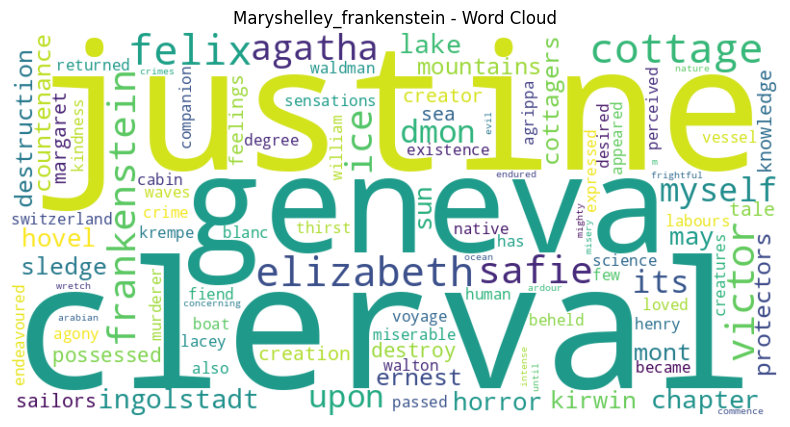

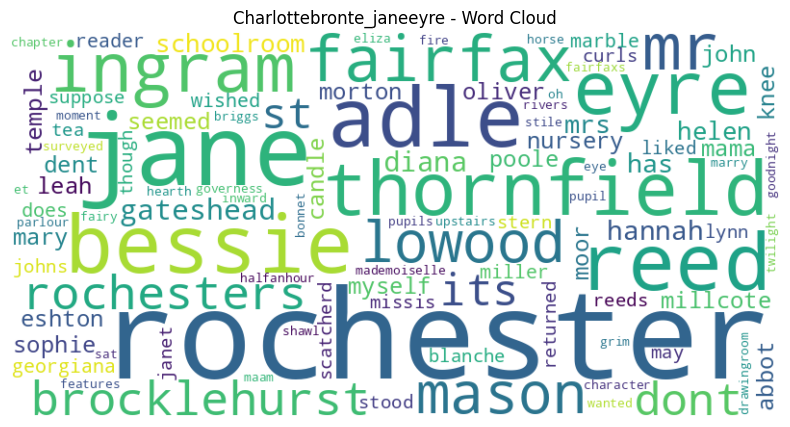

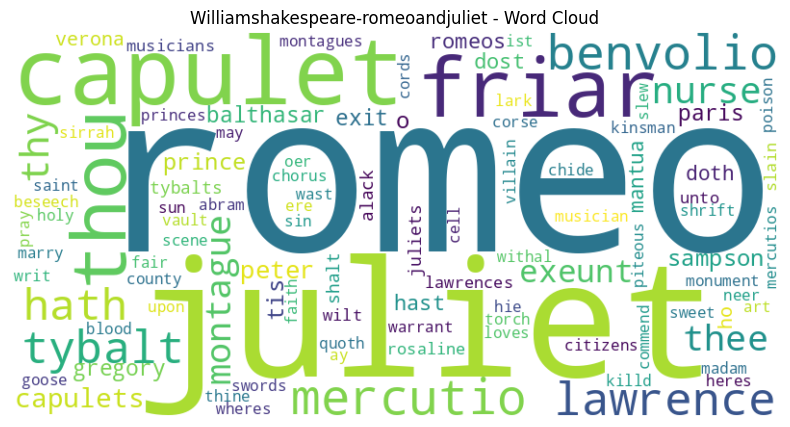

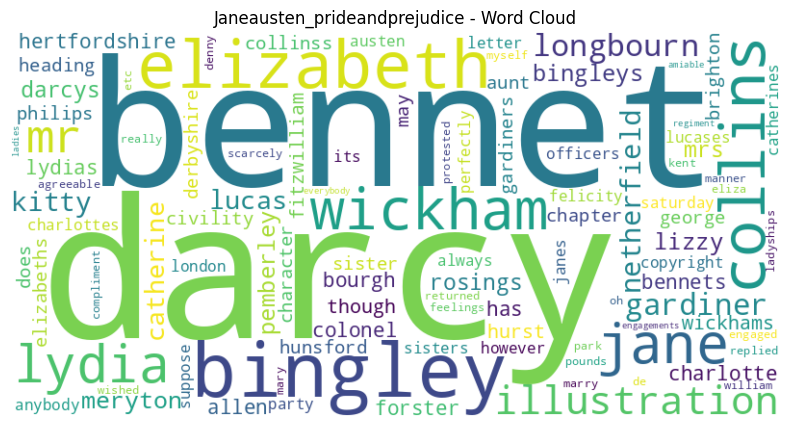

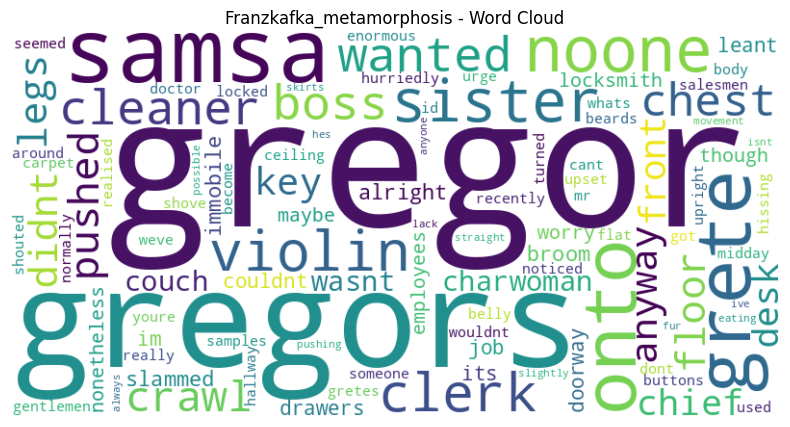

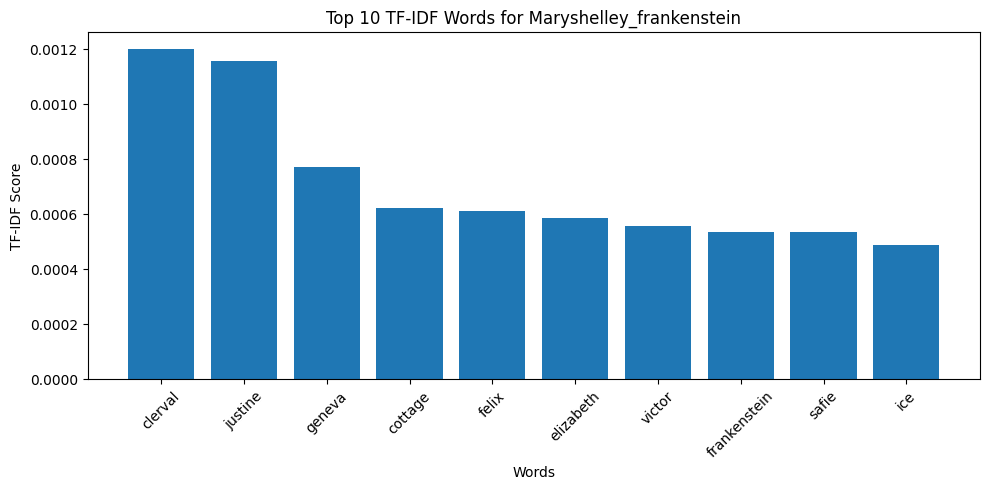

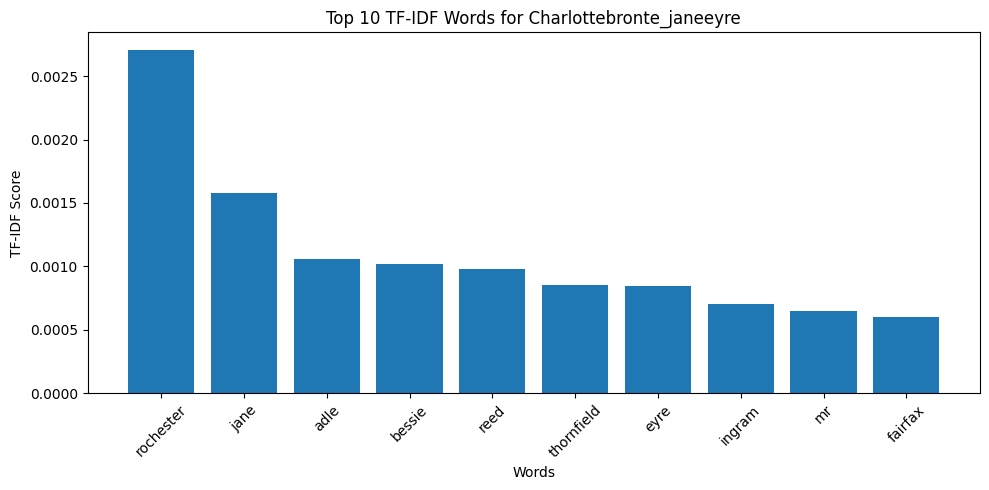

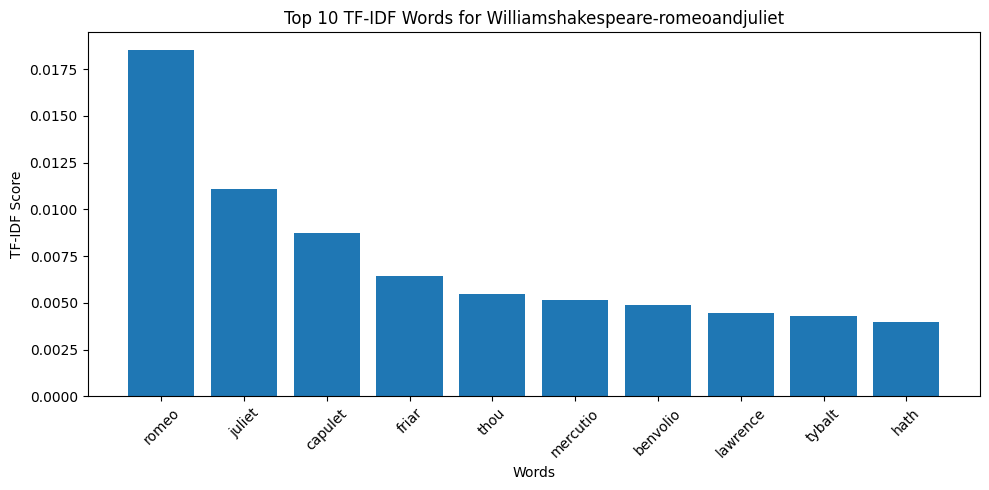

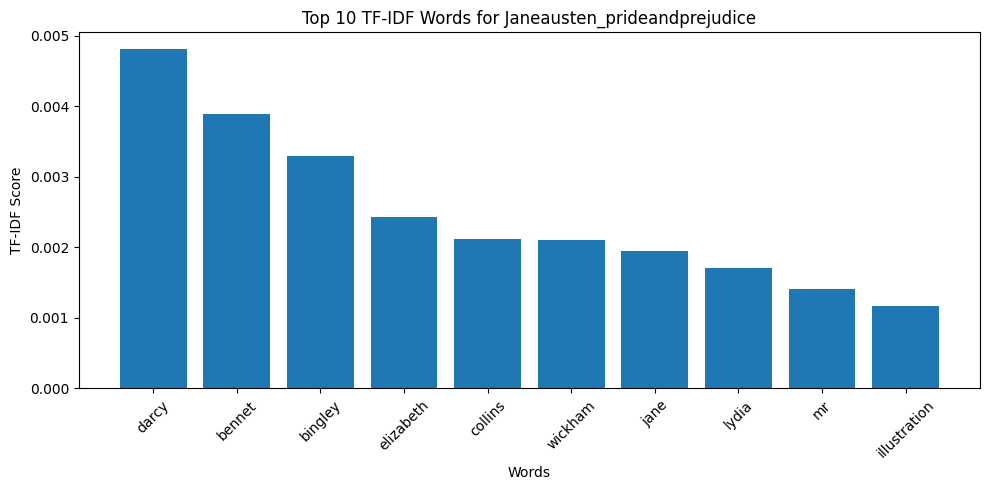

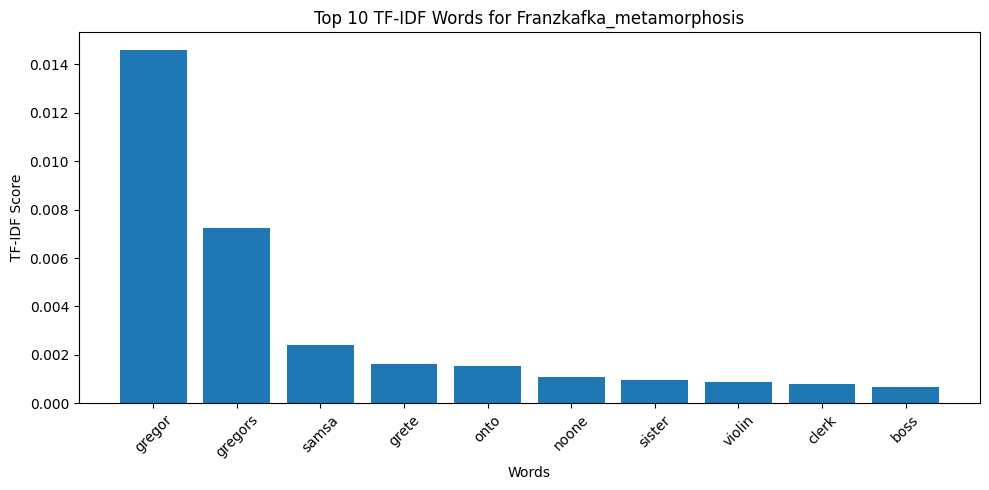



=== Term Significance Across Authors ===

Words that appear in the top 100 for ALL authors (0 terms):
[]

Unique top TF-IDF words per author:
- Maryshelley_frankenstein: clerval, justine, geneva, cottage, felix, victor, frankenstein, safie, ice, agatha...
- Charlottebronte_janeeyre: rochester, adle, bessie, reed, thornfield, eyre, ingram, fairfax, lowood, mason...
- Williamshakespeare-romeoandjuliet: romeo, juliet, capulet, friar, thou, mercutio, benvolio, lawrence, tybalt, hath...
- Janeausten_prideandprejudice: darcy, bennet, bingley, collins, wickham, lydia, illustration, longbourn, gardiner, netherfield...
- Franzkafka_metamorphosis: gregor, gregors, samsa, grete, onto, noone, violin, clerk, boss, cleaner...




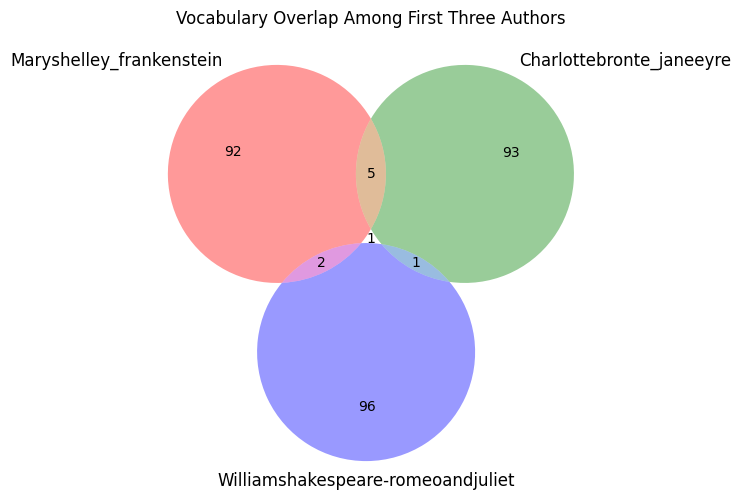



=== Summary Statistics ===


,Author,word_count,vocab_size
0,Maryshelley_frankenstein,74975,7143
1,Charlottebronte_janeeyre,185371,14824
2,Williamshakespeare-romeoandjuliet,25957,3756
3,Janeausten_prideandprejudice,127160,7199
4,Franzkafka_metamorphosis,21942,2687


In [29]:
# Author Style Analysis using TF-IDF and Word Clouds

import os
import re
import math
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from collections import Counter, defaultdict
from wordcloud import WordCloud
import pandas as pd

# Set your folder path ('.' for current working directory, especially for Colab)
FOLDER = "."

def preprocess_text(text):
    # Remove Gutenberg headers/footers
    text = re.split(r"\*\*\* START OF.*?\*\*\*", text, flags=re.DOTALL)[-1]
    text = re.split(r"\*\*\* END OF.*?\*\*\*", text, flags=re.DOTALL)[0]
    # Remove tables/footnotes (non-prose content with multiple hyphens or tabs)
    text = re.sub(r'-{2,}', '', text)
    text = re.sub(r'\t+', ' ', text)
    # Normalize case & remove punctuation
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return words

# Load and preprocess all texts
corpus = {}

if not os.path.exists(FOLDER):
    raise FileNotFoundError(f"The folder path '{FOLDER}' does not exist. Please check the path.")

for filename in os.listdir(FOLDER):
    if filename.lower().endswith(".txt"):
        author = os.path.splitext(filename)[0].strip().capitalize()
        file_path = os.path.join(FOLDER, filename)

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                corpus[author] = preprocess_text(text)
                print(f"✓ Loaded and processed {filename} as '{author}'")
        except Exception as e:
            print(f"❌ Error reading {filename}: {e}")

# Basic statistics: Word count distribution and vocabulary size per author
author_stats = {
    author: {
        "word_count": len(words),
        "vocab_size": len(set(words))
    }
    for author, words in corpus.items()
}

# Compute TF (term frequency)
tf_scores = defaultdict(lambda: defaultdict(float))
df_counts = defaultdict(int)

for author, words in corpus.items():
    total_words = len(words)
    word_counts = Counter(words)
    for word, count in word_counts.items():
        tf_scores[author][word] = count / total_words
        df_counts[word] += 1

# Compute IDF (inverse document frequency)
num_docs = len(corpus)
idf_scores = {
    word: math.log(num_docs / df_counts[word])
    for word in df_counts
}

# Compute TF-IDF for each word in each document
tfidf_scores = defaultdict(lambda: defaultdict(float))
for author in corpus:
    for word in tf_scores[author]:
        tfidf_scores[author][word] = tf_scores[author][word] * idf_scores[word]

# Extract the top 100 most representative words per author
top_words_per_author = {
    author: dict(sorted(tfidf_scores[author].items(), key=lambda x: x[1], reverse=True)[:100])
    for author in corpus
}

# Generate word clouds using TF-IDF scores
for author, word_freq in top_words_per_author.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.title(f"{author} - Word Cloud")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    print("\n")  # Add a newline after each word cloud for visual spacing in the notebook

# Bar chart of top 10 TF-IDF words per author
for author, word_freq in top_words_per_author.items():
    top_10 = dict(list(word_freq.items())[:10])
    plt.figure(figsize=(10, 5))
    plt.bar(top_10.keys(), top_10.values())
    plt.xticks(rotation=45)
    plt.title(f"Top 10 TF-IDF Words for {author}")
    plt.xlabel("Words")
    plt.ylabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()

# Analyze term significance across authors
print("\n\n=== Term Significance Across Authors ===\n")
shared_words = set.intersection(*[set(words.keys()) for words in top_words_per_author.values()])
print(f"Words that appear in the top 100 for ALL authors ({len(shared_words)} terms):")
print(sorted(shared_words))

unique_words_by_author = {
    author: [word for word in top_words_per_author[author] if all(word not in top_words_per_author[other] for other in top_words_per_author if other != author)]
    for author in top_words_per_author
}

print("\nUnique top TF-IDF words per author:")
for author, words in unique_words_by_author.items():
    print(f"- {author}: {', '.join(words[:10])}...")  # Show only first 10 for readability

# Venn diagram for first 3 authors
print("\n")
authors_list = list(top_words_per_author.keys())
if len(authors_list) >= 3:
    set1 = set(top_words_per_author[authors_list[0]].keys())
    set2 = set(top_words_per_author[authors_list[1]].keys())
    set3 = set(top_words_per_author[authors_list[2]].keys())

    plt.figure(figsize=(8, 6))
    venn3([set1, set2, set3], set_labels=(authors_list[0], authors_list[1], authors_list[2]))
    plt.title("Vocabulary Overlap Among First Three Authors")
    plt.show()

# Summary statistics table
print("\n")
print("=== Summary Statistics ===")
summary_table = pd.DataFrame(author_stats).T
summary_table.index.name = "Author"
summary_table.reset_index(inplace=True)
summary_table

# **ECEN 360 - Assignment 5: Author Style Analysis Using TF-IDF and Word Clouds**

### **Objective:**  
This project explored the writing styles of five authors (Austen, Twain, Dickens, Wilde, Shelley) using TF-IDF analysis on texts from Project Gutenberg. The goal was to identify distinctive vocabulary and stylistic patterns in each author's work.

### **Preprocessing:**  
Each plain-text novel was cleaned by removing headers, footers, punctuation, and normalized for case. I calculated word count and vocabulary size for each author.

### **TF-IDF Implementation:**  
Using the formulas from class, I manually computed term frequency (TF), inverse document frequency (IDF), and TF-IDF without using `TfidfVectorizer`. I then extracted the top 100 TF-IDF words per author.

### **Visualization:**  
- Generated word clouds to highlight prominent terms.
- Created bar charts for top 10 TF-IDF words per author.
- Used a Venn diagram to visualize vocabulary overlap among the first three authors.

### **Interpretation of Results:**  
The TF-IDF scores revealed both common and unique vocabulary.  
- **Common words** (e.g., said, time) appeared in all authors’ works and reflect general narrative structure.  
- **Unique words** highlighted thematic or stylistic traits—Shelley leaned toward scientific or Gothic language, while Austen used more societal and romantic vocabulary.  
- The Venn diagram helped visualize stylistic similarity and individuality between authors.


### **Reflection:**  
This assignment deepened my understanding of NLP and how TF-IDF reveals stylistic signatures. Visualizations helped bridge programming with literary analysis.

### **References:**  
- Project Gutenberg  
- Wordcloud example - [Colab Jupyter Notebook Example](https://colab.research.google.com/github/jtao/dswebinar/blob/master/intro_to_ds/case1.1/exploration_example.ipynb)